# Noise Detection

**Cowork by Xurui Chen and Pengzi Li**

[Current receptories, uses and noise level)](#Current)

   - [Current household and manufacturing lots count](#Current_household_and_manufacturing_lots_count)

   - [Land use distribution in study area](#Land_use_distribution_in_study_area)

   - [Peak Time Detection](#Peak_Time_Detection)
   
   - [Heavy_trucks/buses Detection](#Heavy_trucks/buses_detection)

   - [Get Moving Window](#Get_Moving_Window)

   - [Data Filter](#Data_Filter)

   - [Abnormal Detection](#Abnormal_Detection)

[RWCDS additional receptories, uses and noise level](#RWCDS) 

In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib as plt
import seaborn as sns
import matplotlib.ticker as ticker
import ipywidgets as widgets
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as pl

import copy
import urllib
import requests
import geopandas as gpd
import pylab as pl
import shapely
import seaborn as sns
import json
import fiona
from pandas.plotting import scatter_matrix
sns.set_style('whitegrid')
from fiona.crs import from_epsg
from IPython.display import Image
pd.set_option('display.max_columns', 500)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/myEnv3/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'plt', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Current
## receptories, uses and noise level

The study area is zoned to Manufacturing uses under M2-1 zone, and adjucent to R-5 zone. The site is surrounded by 883 residential lots, an high School and 124 manufacturing lots. A block away is a commercial street (Van Brunt st.) which is also a truck route (see truck route nb).

Current noise levels were analyzed based on SONYC sensor located in 373 Van brunt:

## Background

In [ ]:
# url = "https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_mappluto_18v2_1_shp.zip"
# urllib.urlretrieve(url, "file.gz")
# !unzip file.gz

In [2]:
plutoshp = gpd.GeoDataFrame.from_file("MapPLUTO.shp")

In [3]:
plutoshp.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,Sanitboro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,Shape_Leng,Shape_Area,geometry
0,MN,1,10,101,5,1022,02,1,10004,E007,1,15,8100,1,01,3B,1 GOVERNORS ISLAND,R3-2,None,None,None,None,None,GI,None,None,None,N,Y4,08,0,X,GOVERNORS ISLAND CORP,7736692,2725731,2725731,0,0,0,0,0,0,2725731,2,159,0.0,0,0,177.61,0.00,0.0,0.0,None,0,N,5,0,104445450.0,166042350.0,104445450.0,166042350.0,1900,0,0,Governors Island Historic District,INDIVIDUAL LANDMARK,0.35,0.6,0.0,1.0,1,1.000010e+09,0,0005,979071,190225,16a,Y,199 999,10101,None,0.000000e+00,None,1,1,1,18v2.1,12277.824113,7.550340e+06,"POLYGON ((979561.8712409735 191884.2491553128,..."
1,MN,1,101,101,1,1001,02,1,10004,E007,1,15,8200,1,01,None,1 LIBERTY ISLAND,R3-2,None,None,None,None,None,None,None,None,None,N,P7,08,0,X,U S GOVT LAND & BLDGS,541886,541886,541886,0,0,0,0,0,0,541886,2,11,0.0,0,0,500.00,1046.00,0.0,0.0,None,0,Y,5,0,4225950.0,13574700.0,4225950.0,13574700.0,1900,0,0,None,INDIVIDUAL LANDMARK,1.00,0.6,0.0,1.0,1,1.000010e+09,0,0001,971677,190636,16a,Y,199 999,10101,None,0.000000e+00,None,1,None,1,18v2.1,3940.840373,5.018974e+05,(POLYGON ((972382.8255597204 190647.2667211443...
2,MN,1,201,101,1,1000,02,1,10004,E007,1,15,8200,1,01,None,1 ELLIS ISLAND,None,None,None,None,None,None,None,None,None,None,None,Z9,None,0,X,U S GOVT LAND & BLDGS,2764190,603130,603130,0,0,0,0,0,0,603130,2,13,0.0,0,0,63.45,0.00,0.0,0.0,None,0,N,5,0,14972400.0,115055100.0,14972400.0,115055100.0,1900,0,0,Ellis Island Historic District,INTERIOR LANDMARK,0.22,0.0,0.0,0.0,1,1.000010e+09,0,0001,972790,193648,12b,None,199 999,10101,None,0.000000e+00,None,1,None,1,18v2.1,6306.268341,1.148539e+06,"POLYGON ((973154.7118112147 194614.3312935531,..."
3,MN,2,1,101,9,1025,02,1,10004,L015,1,15,7700,1,01,1B,4 SOUTH STREET,M1-4,None,None,None,None,None,LM,None,None,None,N,Y7,07,0,C,NYC DSBS,209215,280000,280000,0,0,0,0,0,0,280000,2,2,5.0,0,1,314.28,564.84,268.0,210.0,None,1,Y,2,0,18818100.0,34154550.0,18818100.0,34154550.0,1908,2006,2006,None,None,1.34,0.0,2.0,6.5,1,1.000020e+09,0,0009,980670,194440,12b,None,101N100,10101,None,1.000020e+09,08/07/2012,1,1,1,18v2.1,2721.060649,1.008250e+05,"POLYGON ((980915.0020648837 194319.1402828991,..."
4,MN,2,2,101,9,1025,02,1,10004,L015,1,15,7700,1,01,1B,10 SOUTH STREET,C4-6,None,None,None,None,None,LM,None,None,None,N,Y7,07,0,C,10 SOUTH STREET LLC,191502,158197,158197,0,0,0,0,0,0,158197,2,1,5.0,0,1,311.61,555.84,205.0,270.0,None,0,Y,2,0,18787500.0,25389900.0,18787500.0,25389900.0,1900,2001,0,None,INDIVIDUAL LANDMARK,0.83,10.0,3.4,10.0,1,1.000020e+09,0,0009,981037,194506,12b,None,11N 100,10101,None,1.000020e+09,08/07/2012,1,1,1,18v2.1,2411.869687,8.724423e+04,"POLYGON ((981169.004181549 194678.8213220537, ..."


## Study Area

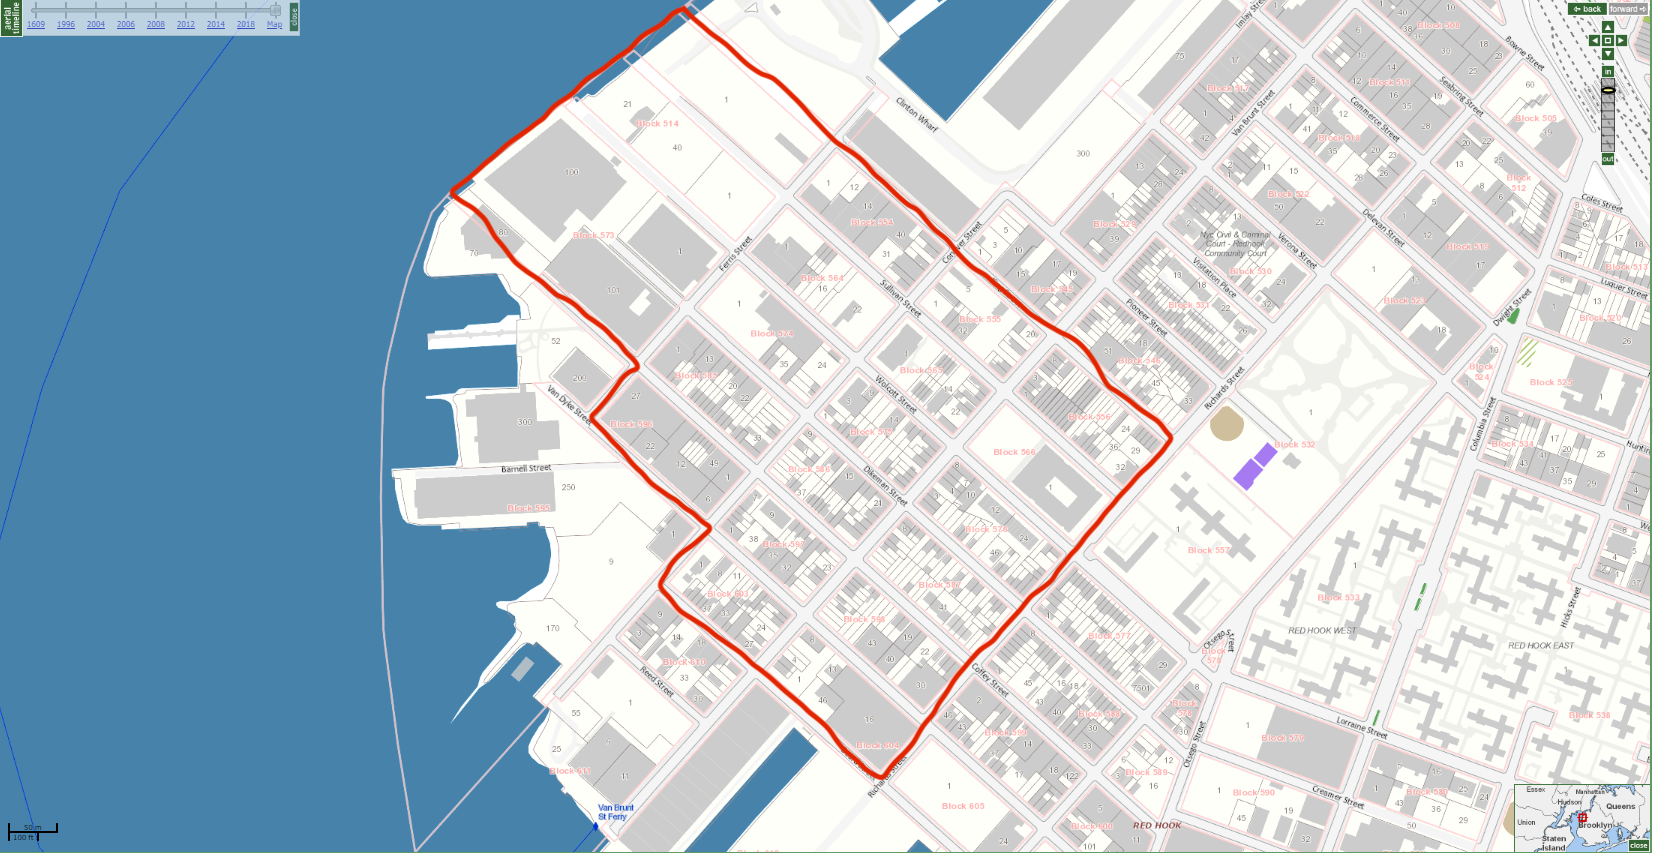

In [4]:
Image('Study_Area.png')

In [5]:
bk_plutoshp = plutoshp[plutoshp.Borough=='BK']
bk_plutoshp.shape
redhook_plutoshp = bk_plutoshp[bk_plutoshp["ZipCode"] == 11231]
redhook_plutoshp.shape
studyarea_block = [514, 515, 554, 555, 556, 564, 565, 566, 573,574, 575, 576, 585, 586, 587, 596, 597, 598, 603, 604]
studyarea_shp = redhook_plutoshp[(redhook_plutoshp["Block"] == 554) | (redhook_plutoshp["Block"] == 555)
                |(redhook_plutoshp["Block"] == 556) |(redhook_plutoshp["Block"] == 564)
                |(redhook_plutoshp["Block"] == 565) |(redhook_plutoshp["Block"] == 566)
                |(redhook_plutoshp["Block"] == 574) |(redhook_plutoshp["Block"] == 575)
                |(redhook_plutoshp["Block"] == 576) |(redhook_plutoshp["Block"] == 585)
                |(redhook_plutoshp["Block"] == 586) |(redhook_plutoshp["Block"] == 587)
                |(redhook_plutoshp["Block"] == 596) |(redhook_plutoshp["Block"] == 597)
                |(redhook_plutoshp["Block"] == 598) | (redhook_plutoshp["Block"] == 603)
                |(redhook_plutoshp["Block"] == 604)|(redhook_plutoshp["Block"] == 573)
                |(redhook_plutoshp["Block"] == 514)|((redhook_plutoshp["Block"] == 515) & (redhook_plutoshp["Lot"] == 1))]

In [6]:
studyarea_shp.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,Sanitboro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,Shape_Leng,Shape_Area,geometry
140932,BK,514,1,306,53,1006,15,38,11231,L101,76,38,4100,3,06,1D,44 FERRIS STREET,M2-1,None,None,None,None,None,None,None,None,None,N,G7,10,0,None,RED HOOK INDUSTRIAL C,50000,600,600,0,0,0,0,0,0,600,2,1,1.0,0,1,200.00,250.00,10.0,60.00,None,0,N,5,5,357480.0,380880.0,0.0,0.0,1931,0,0,None,None,0.01,0.0,2.0,0.0,3,3.005140e+09,0,0053,979883,186919,16a,None,301 003,30205,None,3.005140e+09,03/26/2004,1,1,1,18v2.1,904.133407,50823.268000,"POLYGON ((979724.6891568005 186921.0865094811,..."
140933,BK,514,21,306,53,1006,15,38,11231,L101,76,38,4100,3,06,1D,236 WOLCOTT STREET,M2-1,None,None,None,None,None,None,None,None,None,N,T1,07,0,X,PORT OF N Y AUTHORITY,47000,3294,3294,0,1050,0,0,0,0,2244,2,1,1.0,0,1,251.83,200.00,23.0,85.00,None,0,Y,5,0,469800.0,657450.0,469800.0,657450.0,1931,0,0,None,None,0.07,0.0,2.0,0.0,3,3.005140e+09,0,0053,979512,187252,16a,None,301 003,30205,None,0.000000e+00,None,1,1,1,18v2.1,878.215687,41596.698115,(POLYGON ((979341.5711566359 187254.1544128954...
140934,BK,514,40,306,53,1006,15,38,11231,L101,76,38,4100,3,06,1D,219 SULLIVAN STREET,M2-1,None,None,None,None,None,None,None,None,None,N,G7,10,0,None,RED HOOK INDUSTRIAL C,49740,0,0,0,0,0,0,0,0,0,7,0,0.0,0,0,125.00,100.00,0.0,0.00,None,0,N,5,5,369000.0,369000.0,0.0,0.0,0,0,0,None,None,0.00,0.0,2.0,0.0,3,3.005140e+09,0,0053,979699,187085,16a,None,301 003,30205,None,3.005140e+09,03/26/2004,1,1,1,18v2.1,926.757323,53198.638098,"POLYGON ((979862.2505614758 187079.6997093111,..."
140935,BK,515,1,306,53,1006,15,38,11231,L101,76,38,4100,3,06,1D,42 FERRIS STREET,M2-1,None,None,None,None,None,None,None,None,None,N,G7,10,0,X,GOVERNORS ISLAND CORP,141144,7672,7672,0,7672,0,0,0,0,0,2,1,1.0,0,1,200.00,701.67,25.0,35.00,None,0,Y,5,5,827376.0,1198626.0,827376.0,1198626.0,1980,0,0,None,None,0.05,0.0,2.0,0.0,3,3.005150e+09,0,0053,979879,187259,16a,None,301 003,30205,None,0.000000e+00,None,1,1,1,18v2.1,1752.353536,136393.261528,"POLYGON ((980207.1127326339 187100.2833295614,..."
141286,BK,554,1,306,53,1008,15,38,11231,L101,76,38,4100,3,06,1D,23 FERRIS STREET,M2-1,None,None,None,None,None,None,None,None,None,N,G1,10,0,None,"41 FERRIS, LLC",20000,5820,5820,0,0,0,5820,0,0,0,2,1,1.0,0,1,200.00,100.00,60.0,96.83,None,0,N,3,0,149850.0,929700.0,0.0,0.0,1931,0,0,None,None,0.29,0.0,2.0,0.0,3,3.005540e+09,0,0053,980224,186962,16a,None,301 003,30206,None,0.000000e+00,None,1,1,1,18v2.1,605.316103,20280.353102,"POLYGON ((980329.5232489705 187004.2464481443,..."


(978797.77670617402, 981509.0244332701, 184786.03359454422, 187682.61001924129)

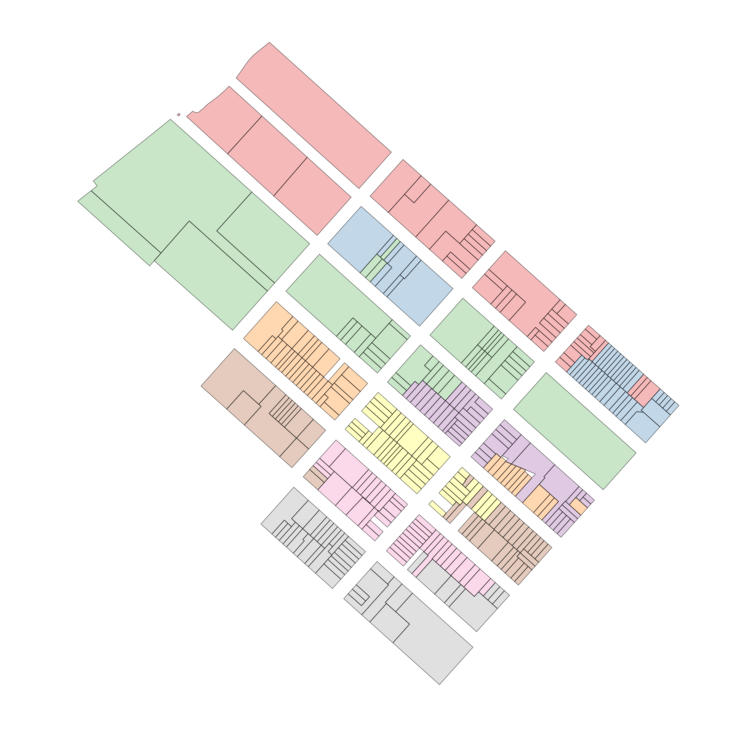

In [7]:
fig = pl.figure(figsize=(13,13)) 
ax = fig.add_subplot(111)
studyarea_shp.geometry.plot(alpha = 0.3, cmap = 'Set1', edgecolor='k', ax=ax)
ax.axis('off')

In [8]:
studyarea_shp["BBL"] = studyarea_shp["BBL"].astype(str)

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
studyarea = studyarea_shp[["BBL","Block","Lot","ZoneDist1","LandUse","BldgArea","ComArea","ResArea","OfficeArea","RetailArea","GarageArea",
                          "StrgeArea","FactryArea","OtherArea","NumBldgs","NumFloors","UnitsRes","UnitsTotal",
                          "BldgDepth","BuiltFAR","ResidFAR","CommFAR","FacilFAR","geometry"]]

In [10]:
studyarea = studyarea.reset_index(drop = True)

## Current_household_and_manufacturing_lots_count

### ZoneDist1
- The zoning district classification of the tax lot.
- Under the Zoning Resolution, the map of New York City is generally apportioned into three basic zoning district categories: Residence (R), Commercial (C) and Manufacturing (M), which are further divided into a range of individual zoning districts, denoted by different number and letter combinations. In general, the higher the number immediately following the first letter (R, C or M), the higher the density or intensity of land use permitted.
- If the tax lot is divided by a zoning boundary line, ZONING DISTRICT 1 represents the zoning district classification occupying the greatest percentage of the tax lot’s area. Only zoning districts that cover at least 10% of a tax lot’s area are included.
- R1-1 - R10H: Residential Districts
- C1-6 - C8-4: Commercial Districts
- M1-1 – M3-2: Manufacturing Districts
- M1-1/R5 – M1-6/R10: Mixed Manufacturing & Residential Districts
- BPC: Battery Park City
- PARK: Areas designated as PARK, BALL FIELD, PLAYGROUND and PUBLIC SPACE in NYC Zoning Districts

In [87]:
set(studyarea_shp['ZoneDist1'])

{u'M1-1', u'M1-1/R5', u'M1-2', u'M2-1', u'R5', u'R6'}

M1-1, M1-2 and M2-1 should be the manufacturing lots. Then we count the number of the study area.

In [88]:
manuLots = studyarea_shp[(studyarea_shp['ZoneDist1']  == 'M1-1') | (studyarea_shp['ZoneDist1']  == 'M1-2') | (studyarea_shp['ZoneDist1']  == 'M2-1')]

In [89]:
manuLots.shape

(124, 90)

**The number of manufacturing lots around the site is 124.**

### UnitsTotal
- Total units: The sum of residential and non-residential (offices, retail stores, etc.) units for all buildings on the tax lot.
- The count of non-residential units is sometimes not available if the building contains residential units.

In [90]:
sum(studyarea_shp['UnitsTotal'])

883

**The number of residential lots around the site is 883.**

## Land_use_distribution_in_study_area

In [11]:
set(studyarea['LandUse'])

{None, u'01', u'02', u'03', u'04', u'05', u'06', u'07', u'08', u'10', u'11'}

In [12]:
sum(studyarea['LandUse'].isna())

15

In [13]:
studyarea['LandUse'].fillna(u'12', inplace = True)

In [14]:
set(studyarea['LandUse'])

{u'01', u'02', u'03', u'04', u'05', u'06', u'07', u'08', u'10', u'11', u'12'}

In [15]:
sum(studyarea['LandUse'].isna())

0

In [16]:
studyarea['LandUse_c'] = studyarea["LandUse"]

In [17]:
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("01", "One&Two Family Buildings")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("02", "Multi-Family Walk-Up Buildings")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("03", "Multi-Family Elevator Buildings")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("04", "Mixed Residential & Commercial Buildings")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("05", "Commercial & Office Buildings")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("06", "Industrial & Manufacturing")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("07", "Transportation & Utility")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("08", "Public Facilities & Institutions")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("09", "Open Space & Outdoor Recreation")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("10", "Parking Facilities")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("11", "Vacant Land")
studyarea['LandUse_c'] = studyarea['LandUse_c'].replace("12", "N/A")

In [18]:
LandUseCount = studyarea.groupby(['LandUse_c']).size().to_frame().rename(columns = {0: 'LandUseCount'})

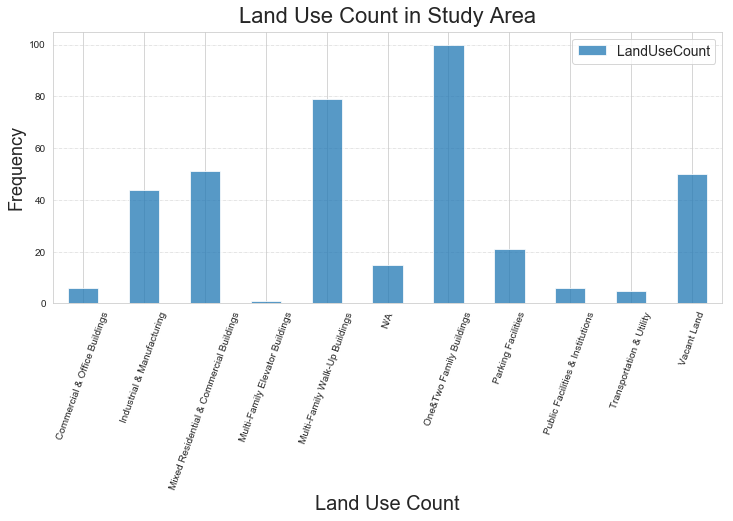

In [19]:
fig = pl.figure(figsize = (12,5))
ax = fig.add_subplot(111)

LandUseCount.plot.bar(label='Land Use Count', alpha=0.75, ax=ax)

ax.set_title("Land Use Count in Study Area", fontsize=22, y=1.01)
ax.set_xlabel("Land Use Count", fontsize=20)
ax.set_ylabel("Frequency", fontsize=18)


pl.grid(linewidth=0.5, axis='y', linestyle='-.')
pl.legend(fontsize=14)
plt.xticks(rotation=70)
pl.show()

In [20]:
dummies = pd.get_dummies(studyarea.LandUse_c)

In [21]:
dummies = pd.concat([studyarea, dummies],axis=1)

In [22]:
lu1 = dummies[dummies["One&Two Family Buildings"]==1]
lu2 = dummies[dummies["Multi-Family Walk-Up Buildings"]==1]
lu3 = dummies[dummies["Multi-Family Elevator Buildings"]==1]
lu4 = dummies[dummies["Mixed Residential & Commercial Buildings"]==1]
lu5 = dummies[dummies["Commercial & Office Buildings"]==1]
lu6 = dummies[dummies["Industrial & Manufacturing"]==1]
lu7 = dummies[dummies["Transportation & Utility"]==1]
lu8 = dummies[dummies["Public Facilities & Institutions"]==1]
# lu9 = dummies[dummies["Open Space & Outdoor Recreation"]==1] #we don't have this kind of land use in our study area
lu10 = dummies[dummies["Parking Facilities"]==1]
lu11 = dummies[dummies["Vacant Land"]==1]
lu12 = dummies[dummies["N/A"]==1]

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/geopandas/plotting.py:404: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/geopandas/plotting.py:404: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/geopandas/plotting.py:404: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/geopandas/plotting.py:404: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/geopandas/plotting.py:404: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/geopandas/plotting.py:404: UserWarning: Only specify one of 'column' or 'color'

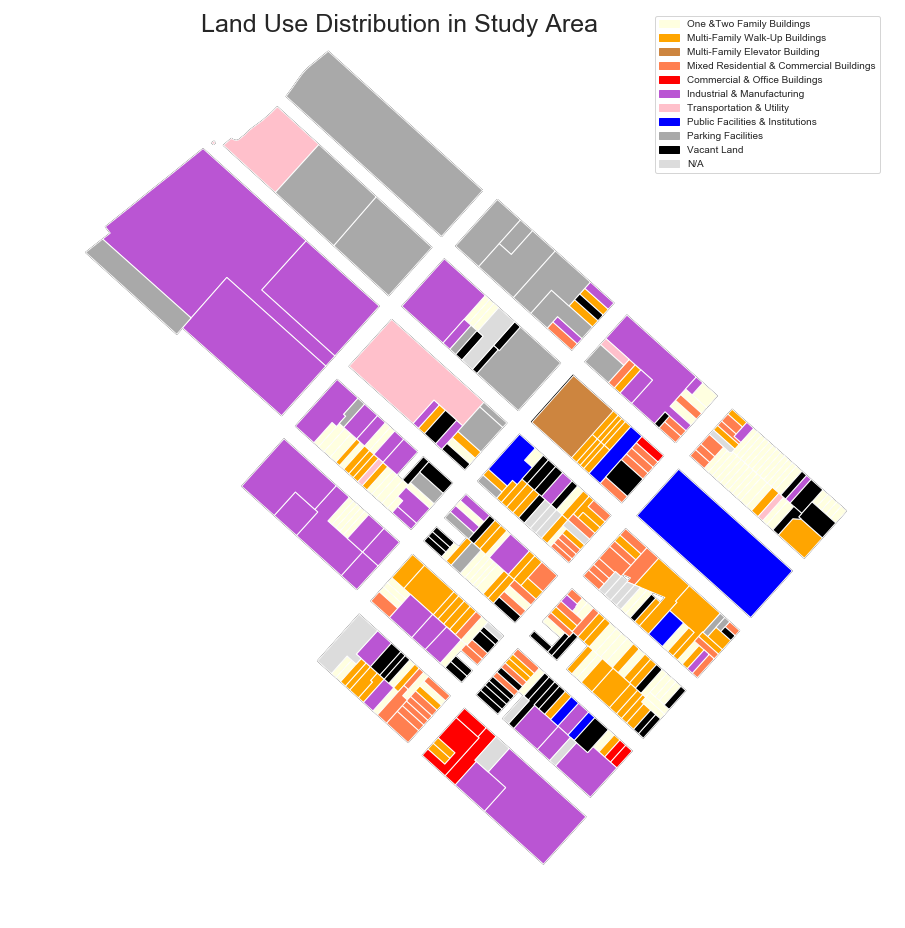

In [23]:
import matplotlib.patches as mpatches
fig = pl.figure(figsize=(15,18))
sns.set_style("whitegrid")

ax = fig.add_subplot(111)
dummies.plot(facecolor="k", edgecolor="k",ax=ax)
lu1.plot(column ="One &Two Family Buildings", color="lightyellow", ax=ax)
lu2.plot(column = "Multi-Family Walk-Up Buildings", color="orange", ax=ax)
lu3.plot(column = "Multi-Family Elevator Buildings", color="peru", ax=ax)
lu4.plot(column = "Mixed Residential & Commercial Buildings", color="coral",ax=ax)
lu5.plot(column = "Commercial & Office Buildings", color="red",ax=ax)
lu6.plot(column = "Industrial & Manufacturing", color="mediumorchid",ax=ax)
lu7.plot(column = "Transportation & Utility", color="pink",ax=ax)
lu8.plot(column = "Public Facilities & Institutions", color="blue",ax=ax)
lu10.plot(column = "Parking Facilities", color="darkgray",ax=ax)
lu11.plot(column = "Vacant Land", color="black",ax=ax)
lu12.plot(column = "N/A", color="gainsboro",ax=ax)
pl.title('Land Use Distribution in Study Area', size=25, y=.97, x=0.42)
l1 = mpatches.Patch(color = "lightyellow", label = "One &Two Family Buildings")
l2 = mpatches.Patch(color = "orange", label = "Multi-Family Walk-Up Buildings")
l3 = mpatches.Patch(color = "peru", label = "Multi-Family Elevator Building")
l4 = mpatches.Patch(color = "coral", label = "Mixed Residential & Commercial Buildings")
l5 = mpatches.Patch(color = "red", label = "Commercial & Office Buildings")
l6 = mpatches.Patch(color = "mediumorchid", label = "Industrial & Manufacturing")
l7 = mpatches.Patch(color = "pink", label = "Transportation & Utility")
l8 = mpatches.Patch(color = "blue", label = "Public Facilities & Institutions")
l10 = mpatches.Patch(color = "darkgray", label = "Parking Facilities")
l11 = mpatches.Patch(color = "black", label = "Vacant Land")
l12 = mpatches.Patch(color = "gainsboro", label = "N/A")
plt.legend(handles=[l1,l2,l3,l4,l5,l6,l7,l8,l10,l11,l12])
ax.axis('off')
plt.show()

**Most of the bbl in the study area were designed as one&two family buildings from the histogram.**

## Need collaborate with socioeconomics teams to get more background information: # of current household, related receptories info, related analysis etc.

## Peak_Time_Detection

In [24]:
plt.rcParams['timezone'] = 'America/New_York'
df = pd.read_csv('sonycnode-b827eb491436.sonyc.csv')

In [25]:
df['time'] = pd.to_datetime(df['timestamp'].values.astype(np.int64), unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
df.set_index(pd.DatetimeIndex(df['time']), inplace=True)
df.drop(['time', 'timestamp'], axis=1, inplace=True)

In [26]:
df['weekday'] = df.index.weekday
df['min_of_day'] = (df.index.hour * 60.0) + df.index.minute
df['hour_of_day'] = df.index.hour

In [27]:
df.head()

,dBAS,weekday,min_of_day,hour_of_day
time,,,,
2019-04-11 11:14:09-04:00,64.35,3,674.0,11
2019-04-11 11:14:10-04:00,65.92,3,674.0,11
2019-04-11 11:14:11-04:00,69.24,3,674.0,11
2019-04-11 11:14:12-04:00,71.78,3,674.0,11
2019-04-11 11:14:13-04:00,70.70,3,674.0,11


In [28]:
def calc_leq(data):
    return 10 * np.log10(np.mean(10 ** (data / 10)))

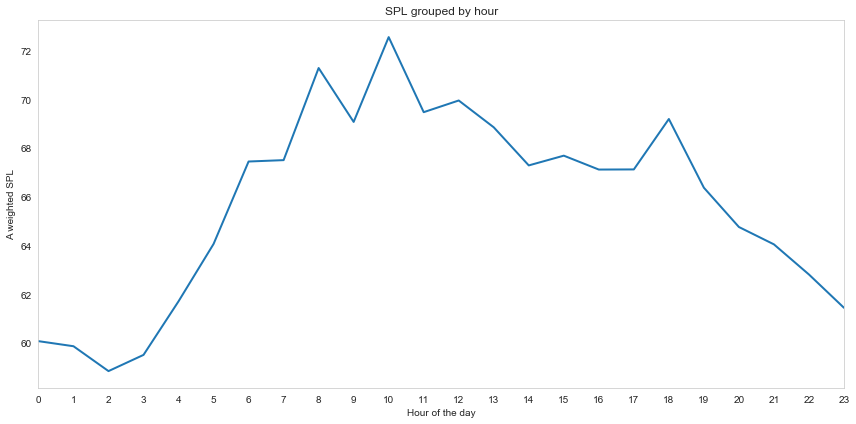

In [29]:
df_gb = df.groupby(df['hour_of_day'])['dBAS'].apply(calc_leq)

plt.figure(figsize=(12,6))
ax = sns.lineplot(x=df_gb.index, y=df_gb, linewidth=2)

plt.xlim([df_gb.index.min(), df_gb.index.max()])
plt.title('SPL grouped by hour')
plt.xlabel('Hour of the day')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel('A weighted SPL')
plt.tight_layout()
plt.grid()

In [30]:
wkday_df = df.loc[df['weekday'] < 5]
wkend_df = df.loc[df['weekday'] > 4]

Plot the mean dBAS changes through the day weekend vs weekday

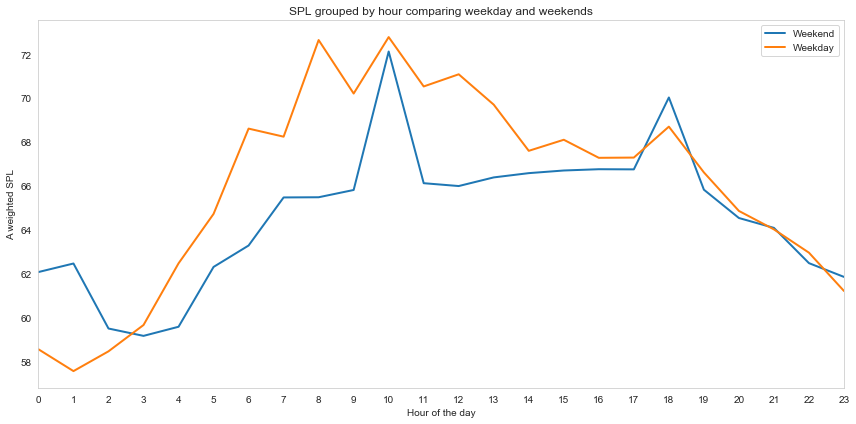

In [31]:
wkend_gb = wkend_df.groupby(wkend_df['hour_of_day'])['dBAS'].apply(calc_leq)
wkday_gb = wkday_df.groupby(wkday_df['hour_of_day'])['dBAS'].apply(calc_leq)

pl.figure(figsize=(12,6))
ax = sns.lineplot(x=wkend_gb.index, y=wkend_gb, linewidth=2)
ax = sns.lineplot(x=wkday_gb.index, y=wkday_gb, linewidth=2)
pl.xlim([wkend_gb.index.min(), wkend_gb.index.max()])
pl.title('SPL grouped by hour comparing weekday and weekends')
pl.xlabel('Hour of the day')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.axvspan(7, 8, alpha=0.5, color='red')
# ax.axvspan(7, 8, alpha=0.5, color='red')
# ax.axvspan(16, 18, alpha=0.5, color='red')
pl.ylabel('A weighted SPL')
pl.legend(['Weekend', 'Weekday'])
pl.tight_layout()
pl.grid()
#pl.savefig('wkend_wkday_byhour.pdf', format='pdf', dpi=1000, bbox_inches='tight')

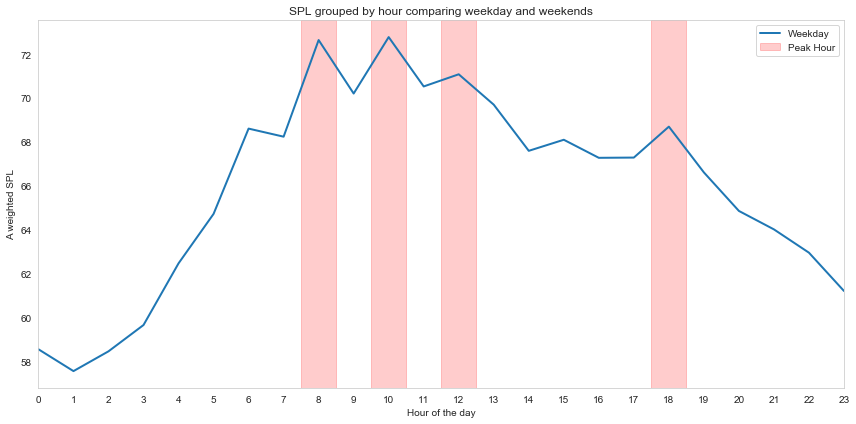

In [32]:
pl.figure(figsize=(12,6))
ax = sns.lineplot(x=wkday_gb.index, y=wkday_gb, linewidth=2)
pl.xlim([wkend_gb.index.min(), wkend_gb.index.max()])
pl.title('SPL grouped by hour comparing weekday and weekends')
pl.xlabel('Hour of the day')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.axvspan(7.5, 8.5, alpha=0.2, color='red')
ax.axvspan(9.5, 10.5, alpha=0.2, color='red')
ax.axvspan(11.5, 12.5, alpha=0.2, color='red')
ax.axvspan(17.5, 18.5, alpha=0.2, color='red')
pl.ylabel('A weighted SPL')
pl.legend(['Weekday', 'Peak Hour'])
pl.tight_layout()
# plt.savefig('wkend_wkday_byhour.pdf', format='pdf', dpi=1000, bbox_inches='tight')
pl.grid()
# pl.savefig('peak hour.jpg')

So we select the 8am, 10am, 12pm and 6pm as morning, midday and afternoon peak time.

And we use 7:50-8:10, 9:50-10:10, 11:50-12:10, 17:50-18:10 to analyze.

## Heavy_trucks/buses_detection

In [33]:
df['logdBAS'] = df['dBAS'].apply(lambda x: calc_leq(x))

In [34]:
heavytrucks = df[df['logdBAS'] > 90]

In [35]:
heavytrucks.shape

(294, 5)

**There are 294 heavy trucks/buses passed by from 2019-04-11 16:52 to 2019-04-23 06:41**

In [36]:
heavytrucks['Date'] = heavytrucks.index.to_frame()['time'].apply(lambda x: x.date())

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
heavytrucksCount = heavytrucks.groupby(['Date', 'weekday']).size().to_frame().rename(columns = {0:'HeavyTrucksCount'})

In [38]:
heavytrucksCount.reset_index(inplace=True)

In [39]:
heavytrucksCount['weekday'] = heavytrucksCount['weekday'].replace(0,"Mon")
heavytrucksCount['weekday'] = heavytrucksCount['weekday'].replace(1,"Tue")
heavytrucksCount['weekday'] = heavytrucksCount['weekday'].replace(2,"Wed")
heavytrucksCount['weekday'] = heavytrucksCount['weekday'].replace(3,"Thur")
heavytrucksCount['weekday'] = heavytrucksCount['weekday'].replace(4,"Fri")
heavytrucksCount['weekday'] = heavytrucksCount['weekday'].replace(5,"Sat")
heavytrucksCount['weekday'] = heavytrucksCount['weekday'].replace(6,"Sun")

In [40]:
heavytrucksCount['Date'] = heavytrucksCount['Date'].astype(str)

In [41]:
heavytrucksCount['index'] = heavytrucksCount['Date'].str.cat(heavytrucksCount['weekday'], sep=' ')

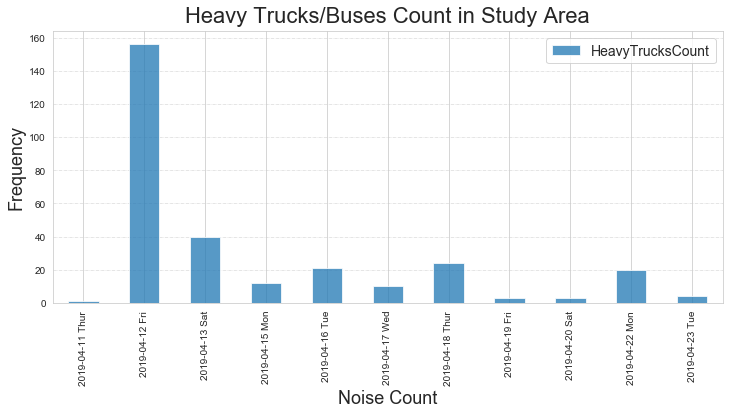

In [42]:
heavytrucksCount.set_index('index', inplace=True)
fig = pl.figure(figsize = (12,5))
ax = fig.add_subplot(111)

heavytrucksCount.plot.bar( alpha=0.75, ax=ax)

ax.set_title("Heavy Trucks/Buses Count in Study Area", fontsize=22, y=1.01)
ax.set_xlabel("Noise Count", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


pl.grid(linewidth=0.5, axis='y', linestyle='-.')
pl.legend(fontsize=14)
pl.show()

**From the histogram, we can observed that April 11(Friday) has the most counts of the heavy trucks/bueses, while the day before it has the least heavy trucks/buses count: only one detected. No obvious trend observed.**

## Get_Moving_Window

In [43]:
rolling_mean = df.dBAS.rolling(window=60).mean()
rolling_std = df.dBAS.rolling(window=60).std()

In [44]:
df['rolling_mean'] = rolling_mean
df['rolling_std'] = rolling_std

In [45]:
df.head()

,dBAS,weekday,min_of_day,hour_of_day,logdBAS,rolling_mean,rolling_std
time,,,,,,,
2019-04-11 11:14:09-04:00,64.35,3,674.0,11,64.35,NaN,NaN
2019-04-11 11:14:10-04:00,65.92,3,674.0,11,65.92,NaN,NaN
2019-04-11 11:14:11-04:00,69.24,3,674.0,11,69.24,NaN,NaN
2019-04-11 11:14:12-04:00,71.78,3,674.0,11,71.78,NaN,NaN
2019-04-11 11:14:13-04:00,70.70,3,674.0,11,70.70,NaN,NaN


## Data_Filter

Filter the data with only the peak time range.

In [46]:
print("The minute of 7:50:")
print(pd.to_datetime('2019-04-11 07:50:09').hour * 60.0 + pd.to_datetime('2019-04-11 07:50:09').minute)
print("The minute of 8:10:")
print(pd.to_datetime('2019-04-11 08:10:09').hour * 60.0 + pd.to_datetime('2019-04-11 08:10:09').minute)

The minute of 7:50:
470.0
The minute of 8:10:
490.0


In [47]:
print("The minute of 9:50:")
print(pd.to_datetime('2019-04-11 09:50:09').hour * 60.0 + pd.to_datetime('2019-04-11 09:50:09').minute)
print("The minute of 10:10:")
print(pd.to_datetime('2019-04-11 10:10:09').hour * 60.0 + pd.to_datetime('2019-10-11 08:10:09').minute)


The minute of 9:50:
590.0
The minute of 10:10:
610.0


In [48]:
print("The minute of 11:50:")
print(pd.to_datetime('2019-04-11 11:50:09').hour * 60.0 + pd.to_datetime('2019-04-11 11:50:09').minute)
print("The minute of 12:10:")
print(pd.to_datetime('2019-04-11 12:10:09').hour * 60.0 + pd.to_datetime('2019-04-11 12:10:09').minute)

The minute of 11:50:
710.0
The minute of 12:10:
730.0


In [49]:
print("The minute of 17:50:")
print(pd.to_datetime('2019-04-11 17:50:09').hour * 60.0 + pd.to_datetime('2019-04-11 17:50:09').minute)
print("The minute of 18:10:")
print(pd.to_datetime('2019-04-11 18:10:09').hour * 60.0 + pd.to_datetime('2019-04-11 18:10:09').minute)

The minute of 17:50:
1070.0
The minute of 18:10:
1090.0


In [50]:
am_peak_df1 = df[(df.min_of_day<490) & (df.min_of_day>=470)]
am_peak_df2 = df[(df.min_of_day<610) & (df.min_of_day>=590)]
mid_peak_df = df[(df.min_of_day<730) & (df.min_of_day>=710)]
pm_peak_df = df[(df.min_of_day<1090) & (df.min_of_day>=1070)]

In [51]:
am_peak_df1['peakLable'] = 1
am_peak_df2['peakLable'] = 2
mid_peak_df['peakLable'] = 3
pm_peak_df['peakLable'] = 4

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [52]:
peak_df = pd.concat([am_peak_df1, am_peak_df2, mid_peak_df, pm_peak_df])

In [53]:
peak_df.shape

(56389, 8)

In [54]:
peak_df.head()

,dBAS,weekday,min_of_day,hour_of_day,logdBAS,rolling_mean,rolling_std,peakLable
time,,,,,,,,
2019-04-12 07:50:00-04:00,73.99,4,470.0,7,73.99,66.112333,8.480796,1
2019-04-12 07:50:01-04:00,74.93,4,470.0,7,74.93,66.433167,8.443483,1
2019-04-12 07:50:02-04:00,75.38,4,470.0,7,75.38,66.763500,8.398471,1
2019-04-12 07:50:03-04:00,76.93,4,470.0,7,76.93,67.124167,8.361977,1
2019-04-12 07:50:04-04:00,77.37,4,470.0,7,77.37,67.461333,8.360428,1


## Abnormal_Detection

In [55]:
print('')
print('Start: \t %s' % peak_df.index[0])
print('End: \t %s' % peak_df.index[-1])
print('')
print('Total avg SPL: \t %0.2f dBA' % peak_df['dBAS'].mean())
print('Total std SPL: \t %0.2f dBA' % peak_df['dBAS'].std())
print('Total max SPL: \t %0.2f dBA' % peak_df['dBAS'].max())
print('Total min SPL: \t %0.2f dBA' % peak_df['dBAS'].min())


Start: 	 2019-04-12 07:50:00-04:00
End: 	 2019-04-22 18:09:59-04:00

Total avg SPL: 	 62.05 dBA
Total std SPL: 	 6.37 dBA
Total max SPL: 	 95.34 dBA
Total min SPL: 	 46.03 dBA


From overall average and standard deviation, we assume that if the noise higher 3 moving_std than this window time moving_avg, there is a significant noise.

In [56]:
def noiseDetection(df):
    return(df[(df['dBAS'] - df['rolling_mean']> 3*df['rolling_std'])])

In [57]:
NoisePoint =  noiseDetection(peak_df)

In [58]:
NoisePoint.shape

(568, 8)

In [59]:
NoisePoint.head()

,dBAS,weekday,min_of_day,hour_of_day,logdBAS,rolling_mean,rolling_std,peakLable
time,,,,,,,,
2019-04-12 07:56:59-04:00,67.71,4,476.0,7,67.71,57.541167,2.985947,1
2019-04-12 07:57:00-04:00,71.44,4,477.0,7,71.44,57.791500,3.479230,1
2019-04-12 07:57:01-04:00,69.49,4,477.0,7,69.49,57.988500,3.792743,1
2019-04-12 07:58:11-04:00,72.21,4,478.0,7,72.21,60.332333,3.762029,1
2019-04-12 07:58:12-04:00,75.11,4,478.0,7,75.11,60.618833,4.203820,1


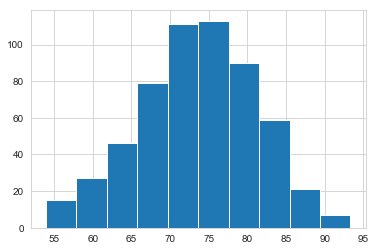

In [60]:
NoisePoint.dBAS.hist()

The distribution of dBAS is nearly a normal distribution, which is robust for analyze.

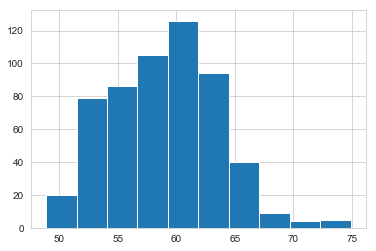

In [61]:
NoisePoint.rolling_mean.hist()

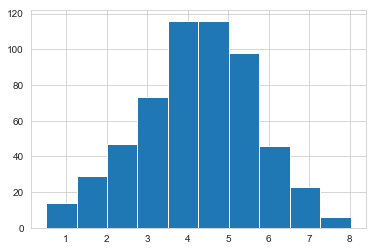

In [62]:
NoisePoint.rolling_std.hist()

The distribution of rolling mean has right skewed distribution, while the distributiob of rolling standard deviation is nearly a normal distribution.

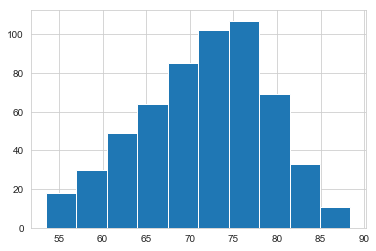

In [63]:
(NoisePoint.rolling_mean + 3*NoisePoint.rolling_std).hist() #thresholds detecting significant noise

The distribution of significant noise has a slightly left skewed distribution, but overall it is similar as the dBAS distribution.

### Analyze by each day and each peak time.

In [64]:
NoisePoint['Date'] = NoisePoint.index.to_frame()['time'].apply(lambda x: x.date())

/anaconda3/envs/myEnv3/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
noiseCount = NoisePoint.groupby(['Date', 'peakLable','weekday']).size().to_frame().rename(columns = {0: 'NoiseCount'})

In [66]:
noiseCount = noiseCount.reset_index()

In [67]:
noiseCount

,Date,peakLable,weekday,NoiseCount
0,2019-04-11,3,3,9
1,2019-04-11,4,3,4
2,2019-04-12,1,4,10
3,2019-04-12,2,4,24
4,2019-04-12,3,4,6
5,2019-04-12,4,4,6
6,2019-04-13,1,5,33
7,2019-04-13,2,5,4
8,2019-04-13,3,5,6
9,2019-04-13,4,5,11


Plot the noise count by each peak Time at each record day

In [68]:
noiseCount = noiseCount.set_index('Date')

In [69]:
noiseCount1 = noiseCount[noiseCount['peakLable'] == 1][['NoiseCount']].reset_index()
noiseCount2 = noiseCount[noiseCount['peakLable'] == 2][['NoiseCount']].reset_index()
noiseCount3 = noiseCount[noiseCount['peakLable'] == 3][['NoiseCount']].reset_index()
noiseCount4 = noiseCount[noiseCount['peakLable'] == 4][['NoiseCount']].reset_index()

In [70]:
noiseCount2

,Date,NoiseCount
0,2019-04-12,24
1,2019-04-13,4
2,2019-04-14,22
3,2019-04-15,12
4,2019-04-16,12
5,2019-04-17,5
6,2019-04-18,27
7,2019-04-19,5
8,2019-04-20,1
9,2019-04-21,19


In [71]:
noiseCountLabel = noiseCount1.merge(noiseCount2, left_on = 'Date', right_on = 'Date', how = 'outer') \
.rename(columns = {'NoiseCount_x': 'NoiseCount_1', 'NoiseCount_y': 'NoiseCount_2'}) \
.merge(noiseCount3, left_on = 'Date', right_on = 'Date', how = 'outer').rename(columns = {'NoiseCount': 'NoiseCount_3'}) \
.merge(noiseCount4, left_on = 'Date', right_on = 'Date', how = 'outer').rename(columns = {'NoiseCount': 'NoiseCount_4'}) \
.reindex([12,0,1,2,3,4,5,6,7,8,9,10,11]).set_index('Date')

In [72]:
noiseCountLabel

,NoiseCount_1,NoiseCount_2,NoiseCount_3,NoiseCount_4
Date,,,,
2019-04-11,NaN,NaN,9.0,4.0
2019-04-12,10.0,24.0,6.0,6.0
2019-04-13,33.0,4.0,6.0,11.0
2019-04-14,23.0,22.0,4.0,7.0
2019-04-15,15.0,12.0,NaN,7.0
2019-04-16,5.0,12.0,15.0,8.0
2019-04-17,17.0,5.0,15.0,13.0
2019-04-18,16.0,27.0,2.0,4.0
2019-04-19,24.0,5.0,4.0,4.0


In [73]:
noiseCountLabel.rename(columns = {"NoiseCount_1":"7:50-8:10","NoiseCount_2":"9:50-10:10",
                                 "NoiseCount_3":"11:50-12:10","NoiseCount_4":"17:50-18:10"}, inplace=True)
noiseCountLabel.head()

,7:50-8:10,9:50-10:10,11:50-12:10,17:50-18:10
Date,,,,
2019-04-11,NaN,NaN,9.0,4.0
2019-04-12,10.0,24.0,6.0,6.0
2019-04-13,33.0,4.0,6.0,11.0
2019-04-14,23.0,22.0,4.0,7.0
2019-04-15,15.0,12.0,NaN,7.0


In [74]:
noiseCountLabel.reset_index(inplace=True)

In [75]:
type(noiseCountLabel['Date'][2])

datetime.date

In [76]:
noiseCountLabel['Weekday'] = noiseCountLabel.Date.apply(lambda x: x.weekday())

In [77]:
noiseCountLabel['Weekday'] = noiseCountLabel['Weekday'].replace(0,"Mon")
noiseCountLabel['Weekday'] = noiseCountLabel['Weekday'].replace(1,"Tue")
noiseCountLabel['Weekday'] = noiseCountLabel['Weekday'].replace(2,"Wed")
noiseCountLabel['Weekday'] = noiseCountLabel['Weekday'].replace(3,"Thur")
noiseCountLabel['Weekday'] = noiseCountLabel['Weekday'].replace(4,"Fri")
noiseCountLabel['Weekday'] = noiseCountLabel['Weekday'].replace(5,"Sat")
noiseCountLabel['Weekday'] = noiseCountLabel['Weekday'].replace(6,"Sun")

In [78]:
type(noiseCountLabel.Weekday[2])

str

In [79]:
noiseCountLabel.head()

,Date,7:50-8:10,9:50-10:10,11:50-12:10,17:50-18:10,Weekday
0,2019-04-11,NaN,NaN,9.0,4.0,Thur
1,2019-04-12,10.0,24.0,6.0,6.0,Fri
2,2019-04-13,33.0,4.0,6.0,11.0,Sat
3,2019-04-14,23.0,22.0,4.0,7.0,Sun
4,2019-04-15,15.0,12.0,NaN,7.0,Mon


In [80]:
noiseCountLabel['Date'] = noiseCountLabel['Date'].astype(str)

In [81]:
noiseCountLabel['index'] = noiseCountLabel['Date'].str.cat(noiseCountLabel['Weekday'], sep=' ')

In [82]:
noiseCountLabel

,Date,7:50-8:10,9:50-10:10,11:50-12:10,17:50-18:10,Weekday,index
0,2019-04-11,NaN,NaN,9.0,4.0,Thur,2019-04-11 Thur
1,2019-04-12,10.0,24.0,6.0,6.0,Fri,2019-04-12 Fri
2,2019-04-13,33.0,4.0,6.0,11.0,Sat,2019-04-13 Sat
3,2019-04-14,23.0,22.0,4.0,7.0,Sun,2019-04-14 Sun
4,2019-04-15,15.0,12.0,NaN,7.0,Mon,2019-04-15 Mon
5,2019-04-16,5.0,12.0,15.0,8.0,Tue,2019-04-16 Tue
6,2019-04-17,17.0,5.0,15.0,13.0,Wed,2019-04-17 Wed
7,2019-04-18,16.0,27.0,2.0,4.0,Thur,2019-04-18 Thur
8,2019-04-19,24.0,5.0,4.0,4.0,Fri,2019-04-19 Fri
9,2019-04-20,34.0,1.0,5.0,5.0,Sat,2019-04-20 Sat


In [83]:
noiseCountLabel.set_index('index', inplace=True)

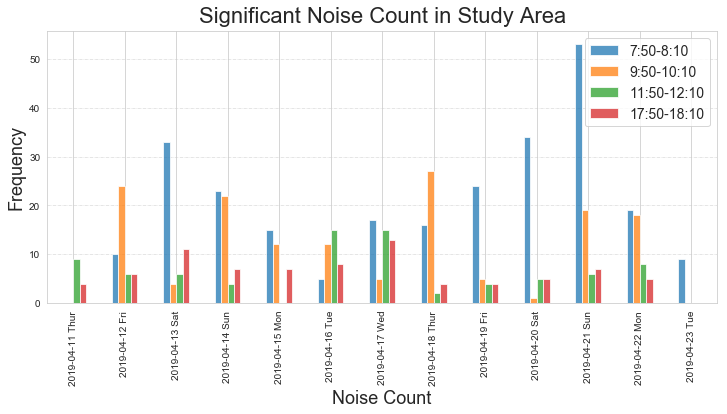

In [84]:
fig = pl.figure(figsize = (12,5))
ax = fig.add_subplot(111)

noiseCountLabel.plot.bar( alpha=0.75, ax=ax)

ax.set_title("Significant Noise Count in Study Area", fontsize=22, y=1.01)
ax.set_xlabel("Noise Count", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


pl.grid(linewidth=0.5, axis='y', linestyle='-.')
pl.legend(fontsize=14)
pl.show()

**In general, most of the significant noise comes from morning peak. Noise from weekend morning counts for the marjor proportion compare to the whole.**

# RWCDS 
## additional receptories, uses and noise level

The study area will be rezoned to M1-4/R7-2 and is predicted to add 2.0 FAR of manufacturing uses, divided to a warehouse (0.66 FAR / sf), Makers' spaces (1.33 FAR / sf) and commercial use (0.6 FAR / sf). # of housing units to be added is 246, and number of office jobs is 125. 

The High School stays in its place.

The warehouse and makers' spaces are considered to be new noise sources, _with a prediction of ? _

The thresholds of noise exposure for the new receptories is list below:

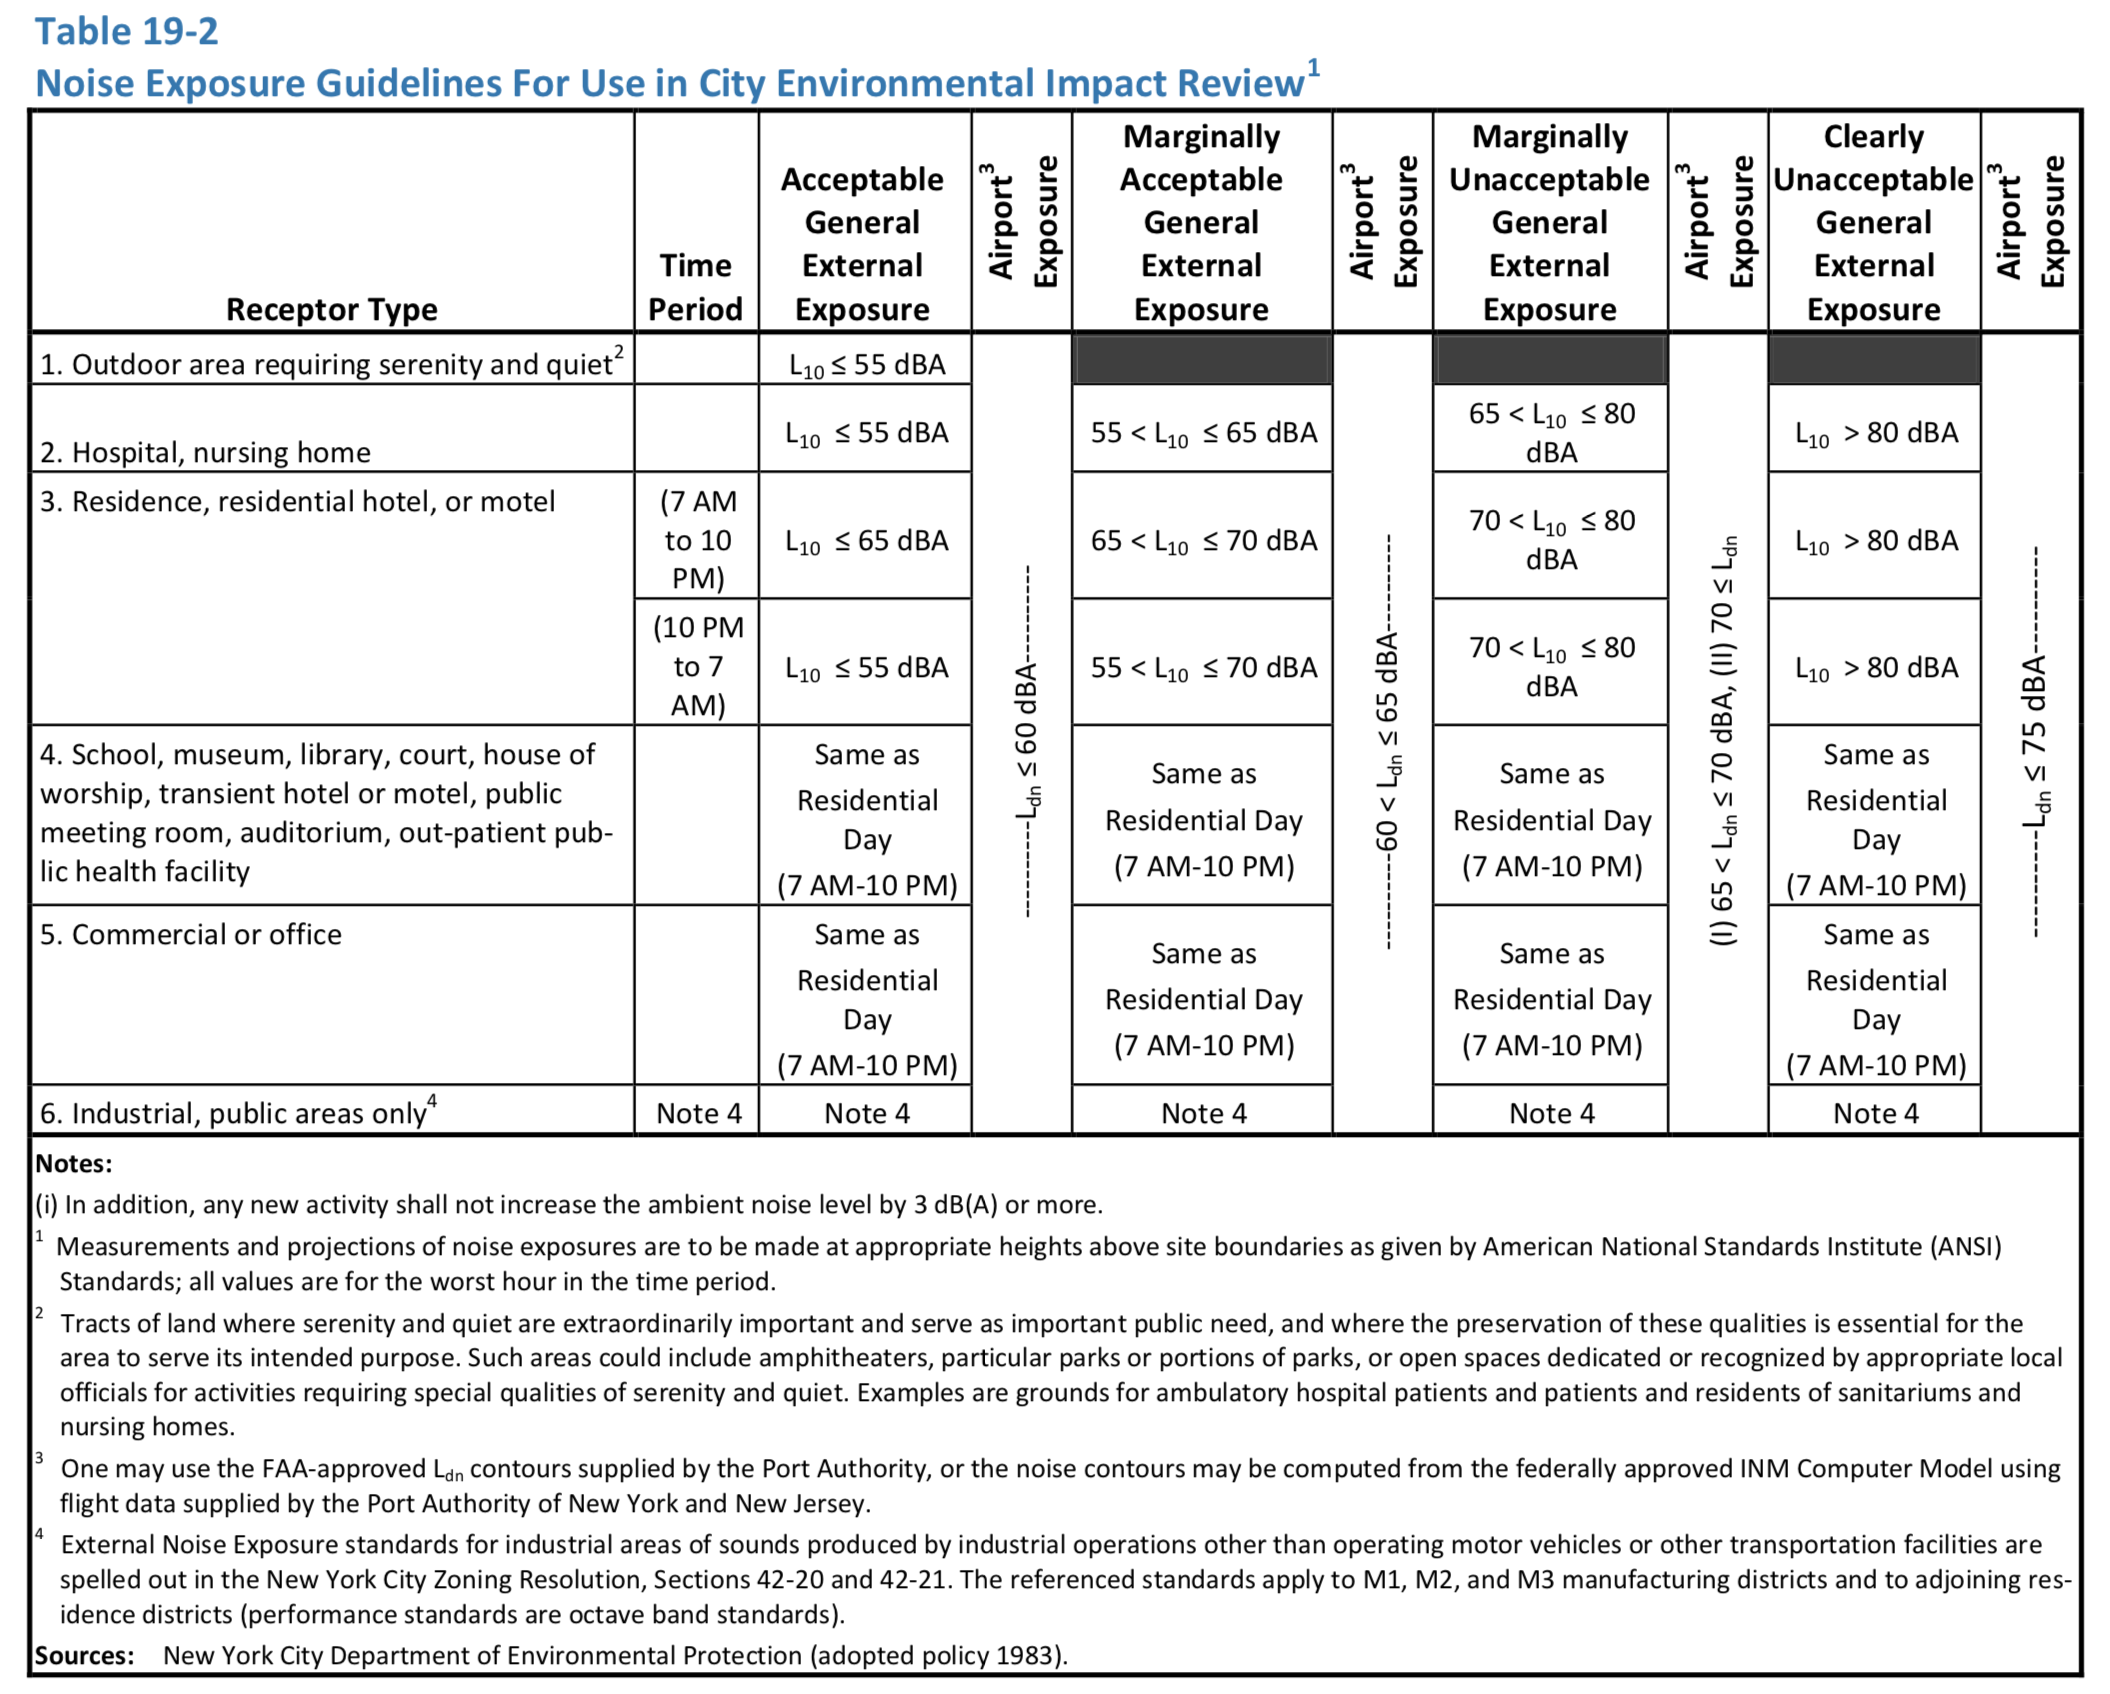

In [85]:
Image('threshold.png')

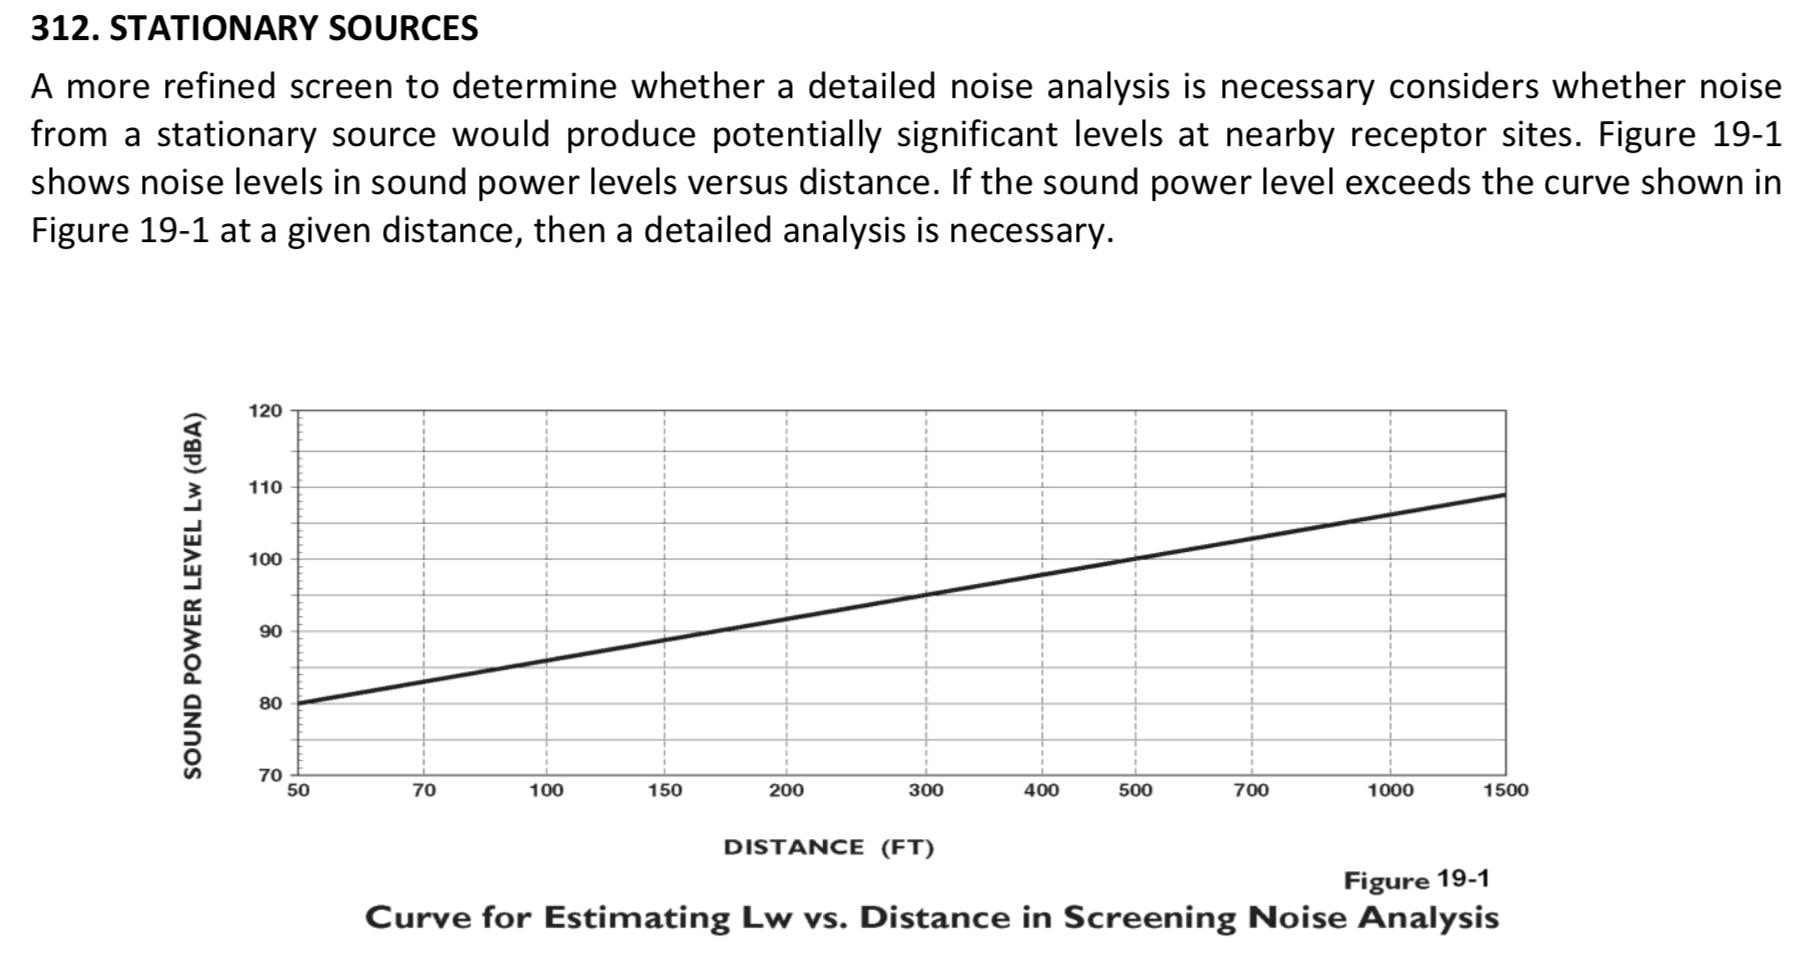

In [86]:
Image('distance.png')

Because the sound pressure level unit of dBA describes a noise level at just one moment and very few noises are constant, other ways of describing noise that fluctuates over extended periods have been developed. One way is to describe the fluctuating sound heard over a specific time period as if it had been a steady, unchanging sound. For this condition, a descriptor called the “equivalent sound level,” $L_{eq}$, can be computed. $L_{eq}$ is the constant sound level that, in a given situation and time period (e.g., 1 hour, denoted by $L_{eq(1)}$, or 24 hours, denoted by $L_{eq(24)}$), conveys the same sound energy as the actual time-varying sound. Statistical sound level descriptors such as $L_1$, $L_{10}$, $L_{50}$, $L_{90}$, and $L_x$, are used to indicate noise levels that are exceeded 1, 10, 50, 90, and x percent of the time, respectively.

The proposed project involves a new stationary source, the analysis should focus on determining maximum $L_{eq(1)}$ values at receptor locations (including the property line) with the stationary source operating. The first step in this calculation is estimating the emission levels from a literature review. Often the data is provided in terms of sound power level. This noise descriptor, expressed in decibels, is a measure of the total acoustic power of a source. It may be used to predict the sound level at a given distance using the formula:

$$ L_p = L_w - 20*log(d) - A_e $$


where:
- $L_p$ is the sound pressure level
- $L_w$ is the sound power level
- d is the distance from the source to the receiver in feet 
- $A_e$ is excess attenuation caused by environmental and terrain features

**Conservative method (involved attenuation)**

Information may be available from industry groups such as the Electric Power Research Institute (EPRI) (3412 Hillview Avenue, Palo Alto, California 94304 USA), in publications such as Electric Power Plant Environmental Noise Guide published by the Edison Electric Institute, or in industry-sponsored computer models. Other alternatives include locating an operating facility with similar equipment and performing measurements at that facility, preferably at similar distances and under similar conditions to those anticipated for the proposed project.

Once data are acquired, the next step is predicting the sound levels at the noise sensitive receptors. Where a single or several discrete sources exist, and where the distances are moderate and have an unobstructed line of sight, this may be accomplished using basic noise fundamentals for calculation (i.e., the addition of sound levels, frequency adjustments to get A-weighted values). For example, if sound power data is available, the equation given above may then be used. If sound level data are available, the following equation may be used to estimate sound levels at a receptor:

$$ L_{p1} = L_{p2} – 20*log(\frac{d1}{d2})$$
where:
- $L_{p1}$ is sound pressure level at the receptor
- $L_{p2}$ is sound pressure level at the reference location 
- $d_1$ is the distance from the source to the receptor 
- $d_2$ is the distance at which the source sound level data is known